<a href="https://colab.research.google.com/github/erikaminarikova/REFRESH/blob/main/example_12_ordinal_sums_ostrava_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.5 MB/s eta 0:00:00


In [2]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [5]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Optimized and safe version
import numpy as np
import math
import pygad
import statistics
import pandas as pd
from sklearn.metrics import f1_score

# ---- Ordinal Sums Functions ---- #
def yes_function(x, y, a, kappa, lam, gamma=1):
    return 1 - np.maximum(0.0, ((1-x)**kappa + (1-y)**kappa - (1-a)**kappa))**(1/kappa)

def no_function(x, y, a, kappa, lam, gamma=1):
    return np.maximum(0.0, (x**lam + y**lam - a**lam))**(1/lam)

def maybe_function(x, y, a, kappa, lam, gamma=1):
    if x is None or y is None:
        return 0
    if gamma == 0:
        return 0
    else:
        value = gamma*(1/a)*x*y + (1-gamma)*(1 - (1/(1-a))*(1-x)*(1-y))
    return statistics.median([0, 1, value])

def classification(x, y, a, kappa, lam, gamma):
    if x < a and y < a:
        return no_function(x, y, a, 1, lam, 1)
    elif x > a and y > a:
        return yes_function(x, y, a, kappa, 1, 1)
    else:
        return maybe_function(x, y, a, 1, 1, gamma)

# ---- Vectorized wrapper ---- #
def classification_vec(values, diffs, a, kappa, lam, gamma):
    if values.size == 0 or diffs.size == 0:
        return np.zeros_like(values)

    results = np.zeros_like(values)
    mask_no = (values < a) & (diffs < a)
    mask_yes = (values > a) & (diffs > a)
    mask_maybe = ~(mask_no | mask_yes)

    if np.any(mask_no):
        results[mask_no] = no_function(values[mask_no], diffs[mask_no], a, 1, lam, 1)
    if np.any(mask_yes):
        results[mask_yes] = yes_function(values[mask_yes], diffs[mask_yes], a, kappa, 1, 1)
    if np.any(mask_maybe):
        for idx in np.where(mask_maybe)[0]:
            results[idx] = maybe_function(values[idx], diffs[idx], a, 1, 1, gamma)

    return np.round(results, 4)

# ---- Genetic Algorithm ---- #
def calculate_param_using_gen_alg(data: pd.DataFrame):
    df = data.copy()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    n_features = X.shape[1]

    def fitness_func(ga_instance, solution, solution_idx):
        try:
            param = np.array(solution, dtype=float)
            value = X[:, 0]
            for j in range(n_features-1):
                diff = X[:, j+1]
                value = classification_vec(value, diff,
                                           param[0], param[1], param[2], param[3])

            error = np.exp2(np.abs(value - y))
            fitness1 = 1.0 / (math.sqrt(np.mean(error)) + 1e-8)  # avoid division by zero

            calc_class = (value >= param[0]).astype(int)
            target_class = (y >= param[0]).astype(int)
            fitness2 = f1_score(target_class, calc_class)

            if np.isnan(fitness1) or np.isnan(fitness2):
                return 0

            return param[4]*fitness1 + (1-param[4])*fitness2

        except Exception as e:
            print(f"Fitness calculation failed: {e}")
            return 0

    ga_instance = pygad.GA(
        num_generations=60,
        num_parents_mating=12,
        fitness_func=fitness_func,
        sol_per_pop=24,
        num_genes=5,
        init_range_low=0,
        init_range_high=1,
        parent_selection_type="tournament",
        K_tournament=3,
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=15,
        gene_space=[
            {'low': 0.1, 'high': 0.9},   # a
            {'low': 0, 'high': 3},       # kappa
            {'low': 0, 'high': 3},       # lambda
            {'low': 0, 'high': 1},       # gamma
            {'low': 0, 'high': 1},       # fitness weight
        ]
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_params = np.array(solution, dtype=float)
    value = X[:, 0]
    for j in range(n_features-1):
        diff = X[:, j+1]
        value = classification_vec(value, diff,
                                   best_params[0], best_params[1], best_params[2], best_params[3])

    error = np.exp2(np.abs(value - y))
    calc_class = (value >= best_params[0]).astype(int)
    target_class = (y >= best_params[0]).astype(int)

    df["calc_value"] = value
    df["error"] = error
    df["calc_value_class"] = calc_class
    df["target_class"] = target_class

    mean_error = np.mean(error)

    return (
        df,                # dataset with calc values
        mean_error,
        best_params[1],    # kappa
        best_params[2],    # lambda
        best_params[3],    # gamma
        best_params[0],    # a
        best_params,       # full parameter vector
        solution_fitness,
        solution_idx
    )


In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [10]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ostrava_housing.csv')

In [13]:
data

,area,ownership,rooms,energy_label,state,equipment,crime_index,quality_index,target
0,83,3,3.5,6,3,3,7.5,1,1849
1,72,1,3.0,2,1,1,5.8,2,5400
2,95,1,3.5,6,1,1,5.8,2,4250
3,25,3,1.5,6,2,2,5.8,2,1790
4,95,1,3.5,6,1,1,5.8,2,4250
...,...,...,...,...,...,...,...,...,...
1688,60,3,3.0,4,2,2,12.1,3,1349
1689,55,1,3.0,6,3,3,12.1,3,1049
1690,68,1,4.0,6,1,3,6.7,2,3890
1691,29,1,1.5,6,1,3,6.7,2,2410


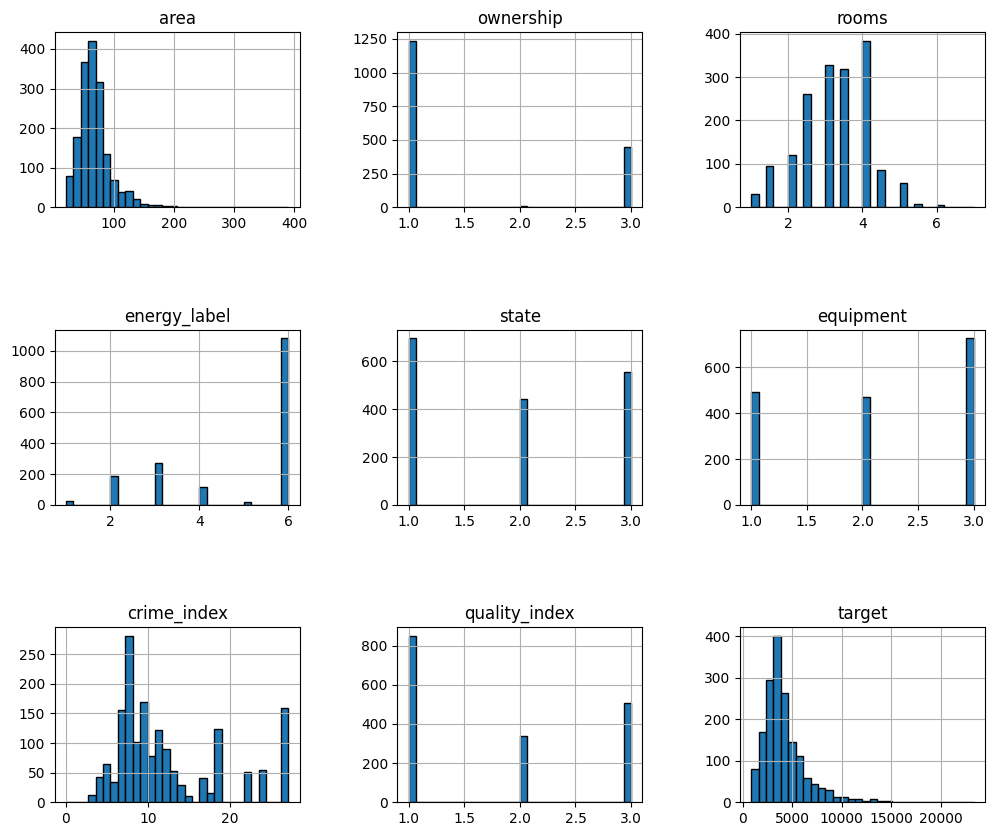

In [14]:
# Grafical representation of distribution of attributes
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [15]:
# decreasing
columns_to_keep = [
    'ownership', 'energy_label', 'state', 'equipment', 'crime_index', 'quality_index'
]

# Normalize each column and add a new "_Normalized" version
for col in columns_to_keep:
    min_val = data[col].min()
    max_val = data[col].max()
    data[f"{col}_Normalized"] = 1- ((data[col] - min_val) / (max_val - min_val))

In [16]:
# increasing
columns_to_keep = [
    'area', 'rooms'
]

# Normalize each column and add a new "_Normalized" version
for col in columns_to_keep:
    min_val = data[col].min()
    max_val = data[col].max()
    data[f"{col}_Normalized"] = (data[col] - min_val) / (max_val - min_val)

In [17]:
# target normalization
def normalize_target(price):
    if price > 7300:
        return 1.0
    elif price < 2160:
        return 0.0
    elif 2160 <= price <= 7300:
        # Linear scaling between 0 and 1
        return (price - 2160) / (7300 - 2160)
    else:
        return 0.0 # Should not happen with the given ranges

data['target_Normalized'] = data['target'].apply(normalize_target)

# Display the first few rows with the new normalized column
print(data[['target', 'target_Normalized']].head())

   target  target_Normalized
0    1849           0.000000
1    5400           0.630350
2    4250           0.406615
3    1790           0.000000
4    4250           0.406615


In [18]:
preprocessed_data = data[[col for col in data.columns if col.endswith('_Normalized')]]

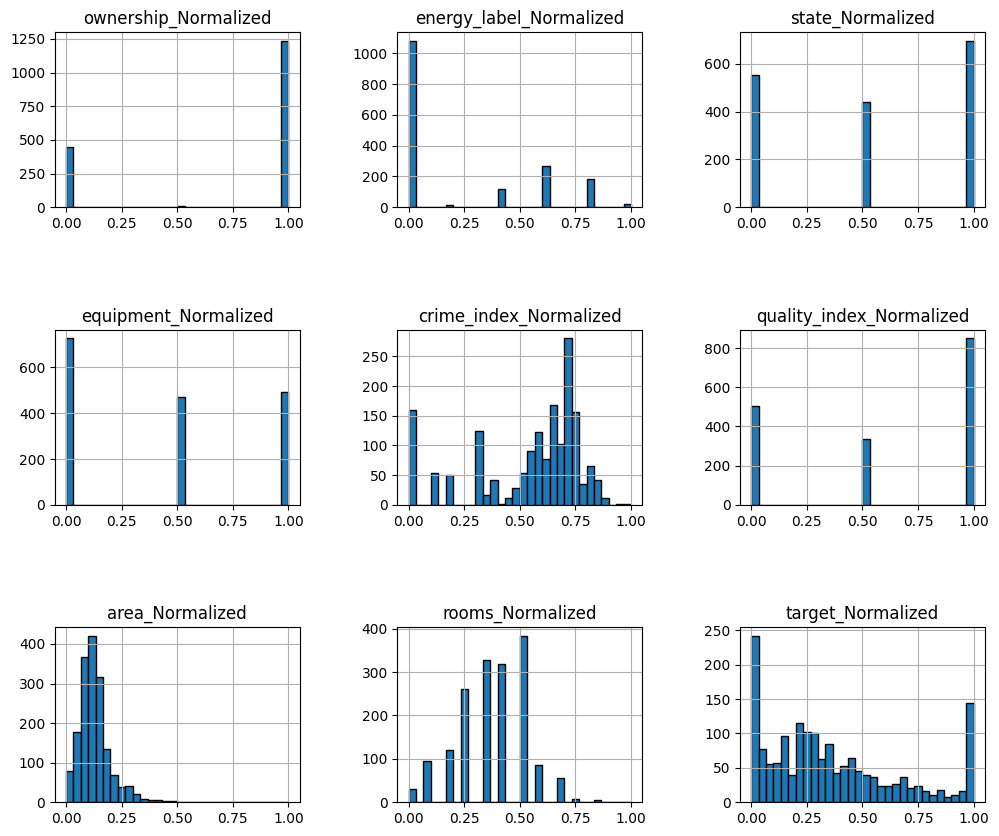

In [19]:
# Grafical representation of distribution of attributes
preprocessed_data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

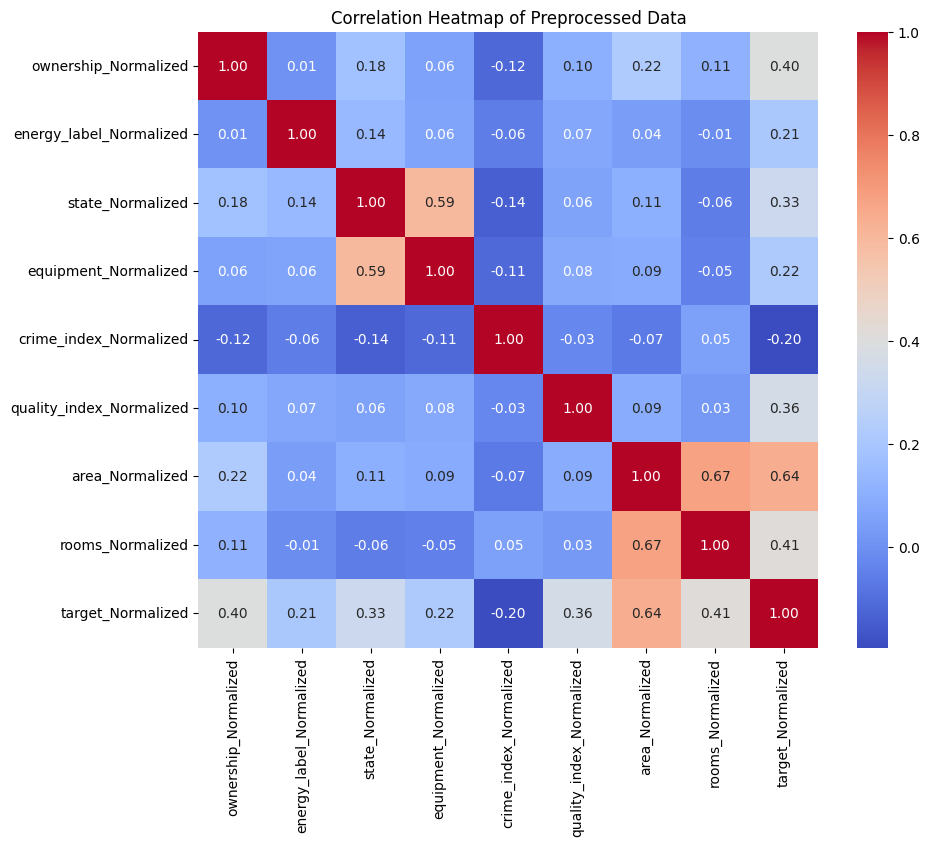

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(preprocessed_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Preprocessed Data')
plt.show()

In [21]:
preprocessed_data['target'] = preprocessed_data['target_Normalized']

In [22]:
data_reordered = preprocessed_data.iloc[:,[1,2,3,4,5,0,7,6,9]]

In [23]:
df_train, df_test = train_test_split(data_reordered, test_size=0.20, random_state=42)

In [24]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print("wages: {w1}, {w2}".format(w1=sol_param[4], w2=1-sol_param[4]))
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

Results:
      energy_label_Normalized  state_Normalized  equipment_Normalized  \
1385                      0.0               0.0                   0.0   
752                       0.0               1.0                   0.5   
408                       0.0               0.0                   0.0   
1653                      0.0               0.0                   0.0   
1216                      0.0               0.0                   0.5   
...                       ...               ...                   ...   
1130                      0.0               1.0                   0.5   
1294                      0.0               1.0                   1.0   
860                       0.0               1.0                   1.0   
1459                      0.0               0.5                   0.0   
1126                      0.0               0.0                   0.0   

      crime_index_Normalized  quality_index_Normalized  ownership_Normalized  \
1385                0.642066      

In [25]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

Accuracy score =  0.7791728212703102
F1 =  0.7787807768786608
Precision =  0.7815808976335357
Recall =  0.7793746727177517


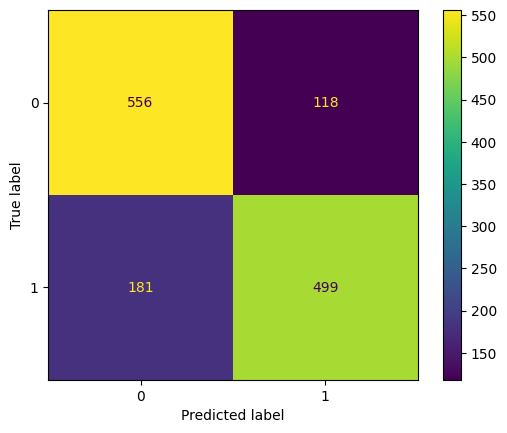

In [26]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

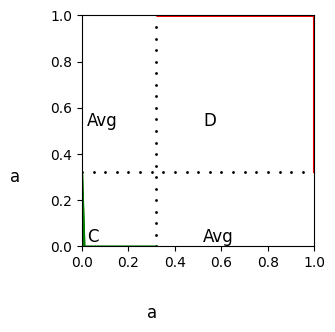

In [27]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(a_result, lam_result, kappa_result)
chart.show()

In [28]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: row[0], axis =1)
# parameters for attributes
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], row[j+1], sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

Results:
      energy_label_Normalized  state_Normalized  equipment_Normalized  \
1263                      0.6               0.5                   0.5   
1685                      0.0               0.0                   0.0   
1556                      0.0               0.0                   0.0   
1176                      0.0               0.0                   0.0   
1374                      0.0               0.5                   0.0   
...                       ...               ...                   ...   
543                       0.0               0.5                   0.5   
1111                      0.6               1.0                   0.5   
987                       0.0               1.0                   1.0   
1175                      0.6               1.0                   1.0   
1483                      0.6               1.0                   0.5   

      crime_index_Normalized  quality_index_Normalized  ownership_Normalized  \
1263                0.719557      

In [29]:
#label calculated value in test dataset to the 2 clasees yes-1, no -0
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']<a_result)else 1, axis=1)
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<a_result)else 1, axis=1)

In [30]:
#prepare test data for tests
target_values = df_test[['target_class']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.7728613569321534
F1 =  0.7713011556287619
Precision =  0.7721908939014202
Recall =  0.7789888682745826


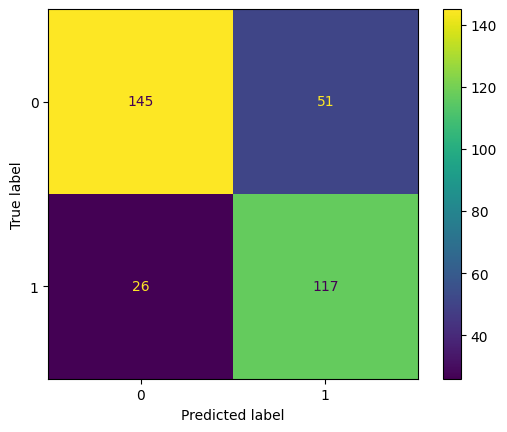

In [31]:
# tests for test dataset:
calculate_tests(target_values, value)

In [32]:
merge_data

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target,calc_value,error,calc_value_class,target_class
1385,0.0,0.0,0.0,0.642066,1.0,1.0,0.333333,0.140541,0.550584,0.5801,1.020670,1,1
752,0.0,1.0,0.5,0.000000,1.0,1.0,0.500000,0.251351,1.000000,0.8388,1.118217,1,1
408,0.0,0.0,0.0,0.575646,1.0,1.0,0.500000,0.156757,0.231518,0.6179,1.307112,1,0
1653,0.0,0.0,0.0,0.516605,0.5,1.0,0.666667,0.386486,1.000000,0.8450,1.113422,1,1
1216,0.0,0.0,0.5,0.608856,0.5,1.0,0.416667,0.108108,0.025292,0.5043,1.393785,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,1.0,0.5,0.723247,0.0,1.0,0.500000,0.124324,0.453307,0.3780,1.053585,1,1
1294,0.0,1.0,1.0,0.793358,0.5,1.0,0.416667,0.270270,0.552335,0.8830,1.257593,1,1
860,0.0,1.0,1.0,0.118081,0.0,1.0,0.250000,0.078378,0.484436,0.0668,1.335737,0,1
1459,0.0,0.5,0.0,0.195572,1.0,1.0,0.333333,0.091892,0.433852,0.3801,1.037961,1,1


In [133]:
df_train['target'] = df_train.apply(lambda row: 0 if (row['target']<a_result)else 1, axis=1)

In [33]:
df_train['target'] = df_train.apply(lambda row: 0 if (row['target']<0.5)else 1, axis=1)

Logistic Regression

In [34]:
from sklearn import linear_model

In [35]:
df_train

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target
1385,0.0,0.0,0.0,0.642066,1.0,1.0,0.333333,0.140541,1
752,0.0,1.0,0.5,0.000000,1.0,1.0,0.500000,0.251351,1
408,0.0,0.0,0.0,0.575646,1.0,1.0,0.500000,0.156757,0
1653,0.0,0.0,0.0,0.516605,0.5,1.0,0.666667,0.386486,1
1216,0.0,0.0,0.5,0.608856,0.5,1.0,0.416667,0.108108,0
...,...,...,...,...,...,...,...,...,...
1130,0.0,1.0,0.5,0.723247,0.0,1.0,0.500000,0.124324,0
1294,0.0,1.0,1.0,0.793358,0.5,1.0,0.416667,0.270270,1
860,0.0,1.0,1.0,0.118081,0.0,1.0,0.250000,0.078378,0
1459,0.0,0.5,0.0,0.195572,1.0,1.0,0.333333,0.091892,0


In [36]:
# Reshaped for logistic regression function
X = df_train.iloc[:, :-1]
y = df_train[["target"]]

Accuracy score =  0.8375184638109305
F1 =  0.7809660787133853
Precision =  0.807218489756297
Recall =  0.7642578554163919


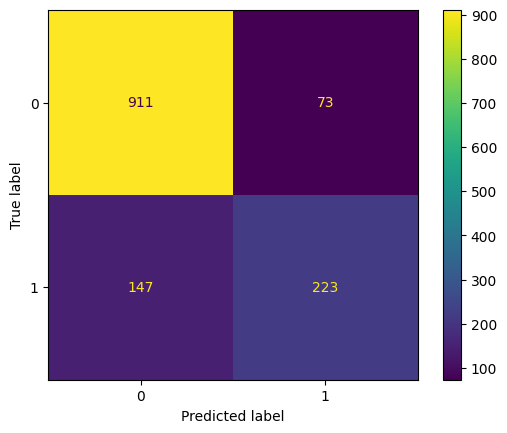

time: 0.0028233806292215983


In [37]:
#train data
start_time = time.time()
logr = linear_model.LogisticRegression()
logr.fit(X,y)
#predict for all input values
predicted=logr.predict(X)
df_train["predicted"]=predicted
# calculate tests for train dataset
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

In [38]:
df_test

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target,calc_value,target_class,calc_value_class
1263,0.6,0.5,0.5,0.719557,0.5,0.0,0.166667,0.072973,0.044747,0.026791,0,0
1685,0.0,0.0,0.0,0.645756,1.0,1.0,0.416667,0.351351,0.000000,1.000000,0,1
1556,0.0,0.0,0.0,0.394834,0.5,1.0,0.333333,0.100000,0.355058,0.204319,1,0
1176,0.0,0.0,0.0,0.723247,0.0,0.0,0.250000,0.089189,0.085603,0.000000,0,0
1374,0.0,0.5,0.0,0.678967,0.5,1.0,0.500000,0.137838,0.455058,0.494335,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
543,0.0,0.5,0.5,0.682657,0.0,1.0,0.416667,0.121622,0.161479,0.181630,0,0
1111,0.6,1.0,0.5,0.723247,0.0,1.0,0.500000,0.129730,0.356031,0.483233,1,1
987,0.0,1.0,1.0,0.712177,1.0,1.0,0.416667,0.118919,0.441245,0.529568,1,1
1175,0.6,1.0,1.0,0.723247,0.0,1.0,0.250000,0.100000,0.367704,0.314034,1,0


In [39]:
#test data
X_t = df_test.iloc[:, :-4]

In [40]:
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']<0.5)else 1, axis=1)

Accuracy score =  0.8407079646017699
F1 =  0.7688636363636363
Precision =  0.8017125210555868
Recall =  0.7488883742473367


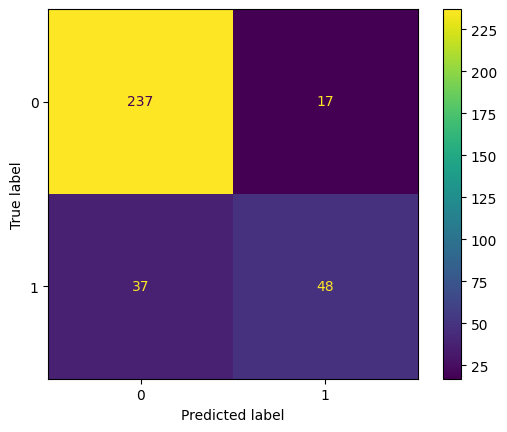

In [41]:
predicted=logr.predict(X_t)
df_test['predicted_test'] = predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted_test']].values
calculate_tests(target_values, value)

Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Accuracy score =  0.843426883308715
F1 =  0.7650598465205207
Precision =  0.8630792766776678
Recall =  0.7320643814546254


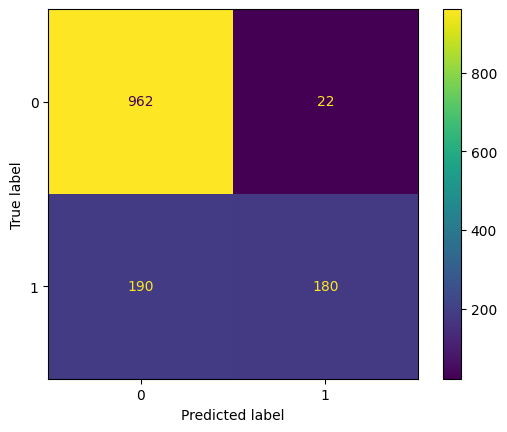

time: 0.005000575383504232


In [43]:
start_time = time.time()
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
predicted=clf.predict(X)
df_train["predicted"]=predicted
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

Accuracy score =  0.8230088495575221
F1 =  0.7001415261233637
Precision =  0.8295149454089852
Recall =  0.6705419175544234


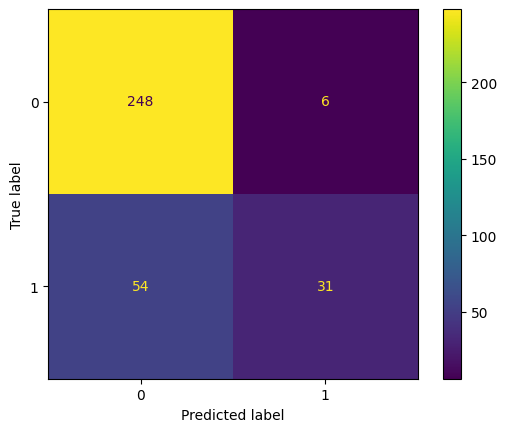

In [44]:
predicted=clf.predict(X_t)
df_test["predicted"]=predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted']].values
calculate_tests(target_values, value)

Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

Accuracy score =  0.8316100443131462
F1 =  0.7959549492385787
Precision =  0.7868513065881487
Recall =  0.8082564271588661


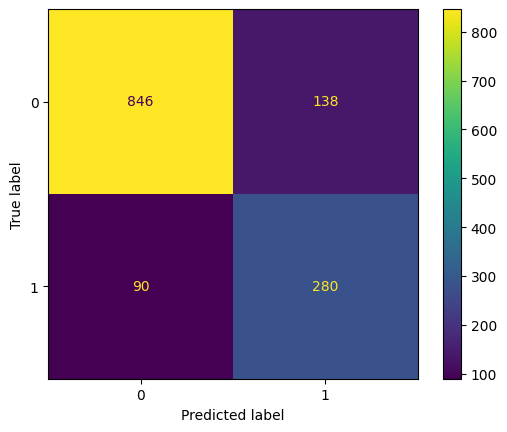

time: 0.0017823417981465658


In [46]:
start_time = time.time()
gnb = GaussianNB()
gnb.fit(X, y)
predicted=gnb.predict(X)
df_train["predicted"]=predicted
# calculate tests for train data
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

Accuracy score =  0.8407079646017699
F1 =  0.7896635720194871
Precision =  0.7874931581828133
Recall =  0.7919407132931913


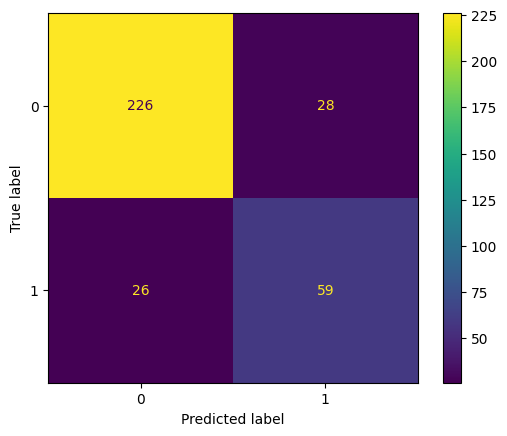

In [47]:
predicted=gnb.predict(X_t)
df_test["predicted"]=predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted']].values
calculate_tests(target_values, value)